In [1]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import glob

In [2]:
data = pd.read_csv('C:/Users/Kemboi Elvis/Downloads/archive/list_attr_celeba.csv')
total_data = pd.concat([data])
path = 'C:/Users/Kemboi Elvis/Downloads/archive/celeba-dataset/img_align_celeba/img_align_celeba/'+total_data.image_id.loc[0]


copy_data = total_data[total_data.Male != ''].copy()
copy_data['Male'] = copy_data['Male'].replace([-1], 0)
copy = copy_data[:10000]
copy.info()
#labels = copy_data.Male
#print(labels.info())
data = []
labels = []

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image_id             10000 non-null  object
 1   5_o_Clock_Shadow     10000 non-null  int64 
 2   Arched_Eyebrows      10000 non-null  int64 
 3   Attractive           10000 non-null  int64 
 4   Bags_Under_Eyes      10000 non-null  int64 
 5   Bald                 10000 non-null  int64 
 6   Bangs                10000 non-null  int64 
 7   Big_Lips             10000 non-null  int64 
 8   Big_Nose             10000 non-null  int64 
 9   Black_Hair           10000 non-null  int64 
 10  Blond_Hair           10000 non-null  int64 
 11  Blurry               10000 non-null  int64 
 12  Brown_Hair           10000 non-null  int64 
 13  Bushy_Eyebrows       10000 non-null  int64 
 14  Chubby               10000 non-null  int64 
 15  Double_Chin          10000 non-null  int64 
 16  Eyegl

In [3]:
Y = 'C:/Users/Kemboi Elvis/Downloads/archive/img_align_celeba/img_align_celeba/' + copy.image_id
for img in Y:
    image = cv2.imread(img)
    image = cv2.resize(image, (96, 96))
    image = img_to_array(image)
    data.append(image)
for label1 in copy.Male:
    if label1 == 0:
        label = 0
    else:
        label = 1

    labels.append([label])

data = np.array(data, dtype='float') / 255.0
# data = np.squeeze(data)/255
labels = np.array(labels)
print(data.shape)
print(labels.shape)


(10000, 96, 96, 3)
(10000, 1)


In [4]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

# augmenting dataset
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# %%


In [5]:
def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":  # Returns a string, either 'channels_first' or 'channels_last'
        inputShape = (depth, height, width)
        chanDim = 1

    # The axis that should be normalized, after a Conv2D layer with data_format="channels_first",
    # set axis=1 in BatchNormalization.

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    # model.add(GlobalAveragePooling2D())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))
    model.summary()

    return model


# %%
model = build(width=96, height=96, depth=3, classes=2)
# Complie model


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [6]:
lr = 1e-3
epochs = 35
opt = Adam(learning_rate=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# %%
# Train model
batch_size = 64
H = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
              validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // batch_size,
              epochs=epochs, verbose=1)
# %%

model.save("gender_detection.model")
# %%

Epoch 1/35
125/125 [==============================] - 155s 1s/step - loss: 0.6686 - accuracy: 0.7265 - val_loss: 1.1947 - val_accuracy: 0.5725
Epoch 2/35
125/125 [==============================] - 117s 935ms/step - loss: 0.5017 - accuracy: 0.7868 - val_loss: 0.7588 - val_accuracy: 0.6085
Epoch 3/35
125/125 [==============================] - 126s 1s/step - loss: 0.4380 - accuracy: 0.8121 - val_loss: 1.1464 - val_accuracy: 0.6845
Epoch 4/35
125/125 [==============================] - 123s 984ms/step - loss: 0.4099 - accuracy: 0.8281 - val_loss: 0.3427 - val_accuracy: 0.8490
Epoch 5/35
125/125 [==============================] - 117s 933ms/step - loss: 0.3354 - accuracy: 0.8602 - val_loss: 0.2574 - val_accuracy: 0.8930
Epoch 6/35
125/125 [==============================] - 119s 948ms/step - loss: 0.2837 - accuracy: 0.8826 - val_loss: 0.2664 - val_accuracy: 0.8865
Epoch 7/35
125/125 [==============================] - 127s 1s/step - loss: 0.2652 - accuracy: 0.8891 - val_loss: 0.2102 - val_accu

In [7]:
score = model.evaluate(testX, testY, verbose=0)
print('\n', 'Test accuracy:', score[1] * 100, '%')


 Test accuracy: 96.05000019073486 %


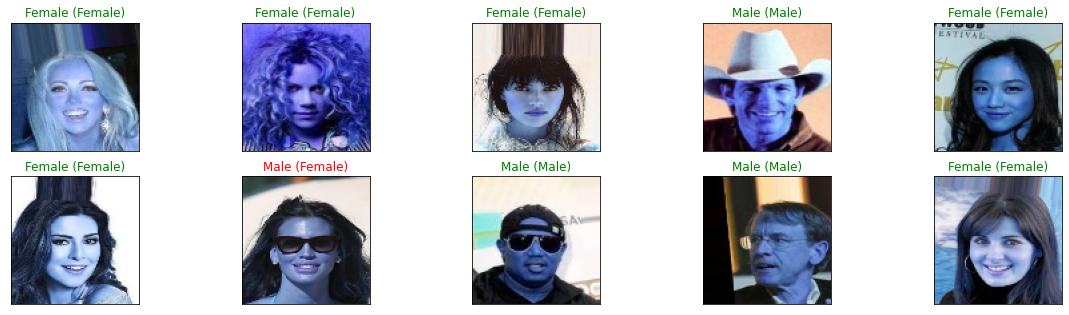

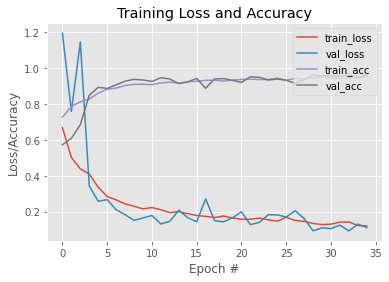

In [8]:
labels = [
    "Female",  # index 0
    "Male",  # index 1
]
y_hat = model.predict(testX)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(testX.shape[0], size=10, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(testX[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(testY[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index],
                                  labels[true_index]),
                 color=("green" if predict_index == true_index else "red"))
plt.show()
# %%
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('plot.png')
# %%